In [1]:
# !pip install keras-tuner

# from google.colab import drive
# drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
import os
import sys
import time
import glob
import random
import argparse
import pickle
import numpy as np
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import lfilter
import scipy.signal as signal
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Add, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten,
    Conv2D, DepthwiseConv2D, MaxPooling2D,
    BatchNormalization, GlobalAveragePooling2D,
    Add
)
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D,
    Dense, Dropout, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# %matplotlib inline

class DataSet2(object):

    def __init__(self, images, labels, img_names, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._img_names = img_names
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._img_names

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._img_names[start:end], self._cls[start:end]

def read_train_sets2(train_path, classes, validation_size):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, img_names, cls = load_train2(train_path, classes)  # 2 calculating, 3 loading
    images, labels, img_names, cls = shuffle(images, labels, img_names, cls)

    if isinstance(validation_size, float):
        validation_size = int(validation_size * images.shape[0])

    validation_images = images[:validation_size]
    validation_labels = labels[:validation_size]
    validation_img_names = img_names[:validation_size]
    validation_cls = cls[:validation_size]

    train_images = images[validation_size:]
    train_labels = labels[validation_size:]
    train_img_names = img_names[validation_size:]
    train_cls = cls[validation_size:]
#     print('Training dataset shape:',len (train_images))
    data_sets.train = DataSet2(train_images, train_labels, train_img_names, train_cls)
    data_sets.valid = DataSet2(validation_images, validation_labels, validation_img_names, validation_cls)

    return data_sets

def load_train2(train_path, classes):
    samples = []
    labels = []
    sample_names = []
    cls = []

    for fields in classes:
        index = classes.index(fields)
        path = os.path.join(train_path, fields, '*.npy')
        files = glob.glob(path)
        for fl in files:
            iq_samples = np.load(fl)
            real = np.real(iq_samples)
            imag = np.imag(iq_samples)

            iq_samples = np.ravel(np.column_stack((real, imag)))

            multiple = False
            if multiple:
                iq_samples1 = iq_samples[:1568]
                iq_samples1 = iq_samples1.reshape(28, 28, 2)
                iq_samples2 = iq_samples[1568:3136]
                iq_samples2 = iq_samples2.reshape(28, 28, 2)
                iq_samples3 = iq_samples[3136:4704]
                iq_samples3 = iq_samples3.reshape(28, 28, 2)
                iq_samples4 = iq_samples[4704:6272]
                iq_samples4 = iq_samples4.reshape(28, 28, 2)
                samples.append(iq_samples1)
                samples.append(iq_samples2)
                samples.append(iq_samples3)
                samples.append(iq_samples4)

                flbase = os.path.basename(fl)
                label = np.zeros(len(classes))
                label[index] = 1.0

                labels.append(label)
                labels.append(label)
                labels.append(label)
                labels.append(label)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                sample_names.append(flbase)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
                cls.append(fields)
            else:
                iq_samples = iq_samples[:1568]
                iq_samples = iq_samples.reshape(28, 28, 2)
                samples.append(iq_samples)

                label = np.zeros(len(classes))
                label[index] = 1.0
                labels.append(label)
                flbase = os.path.basename(fl)
                sample_names.append(flbase)
                cls.append(fields)

    samples = np.array(samples)
    labels = np.array(labels)
    sample_names = np.array(sample_names)
    cls = np.array(cls)
    return samples, labels, sample_names, cls

# Function to read the samples from _prediction_samples.dat files

def read_samples_sdr(freq):
    sdr = RtlSdr()
    sdr.sample_rate = sample_rate
    sdr.err_ppm = 56   # change it to yours
    sdr.gain = 'auto'

    f_offset = 250000  # shifted tune to avoid DC
    sdr.center_freq = freq - f_offset
    time.sleep(0.06)
    iq_samples = sdr.read_samples(1221376)
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples


def read_samples(freq):
    f_offset = 250000  # Shifted tune to avoid DC
    samp = np.fromfile(str(freq)+'_prediction_samples.dat',np.uint8)+np.int8(-127) # Adding a signed int8 to an unsigned one results in an int16 array
    x1 = samp[::2]/128 # Even samples are real(In-phase)
    x2 = samp[1::2]/128 # Odd samples are imaginary(Quadrature-phase)
    iq_samples = x1+x2*1j # Create the complex data samples
    iq_samples = iq_samples[0:600000]
    fc1 = np.exp(-1.0j * 2.0 * np.pi * f_offset / sample_rate * np.arange(len(iq_samples)))  # Shift down 250kHz
    iq_samples = iq_samples * fc1
    return iq_samples

########### Main Code #################################

############ Data for training the model #################
train_path =r'C:\Users\USER\Downloads\training_data-20250805T135948Z-1-001\training_data'
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))] # Gets classes from all the folders mentioned under training_data folder
print(classes)
# classes = ['BPSK','GMSK','QPSK']
num_classes = len(classes)
data = read_train_sets2(train_path, classes, validation_size=0.3) # Gets the data object using a class in dataset2.py

Xtrain = data.train.images
Ytrain = data.train.labels
Xtest = data.valid.images
Ytest = data.valid.labels

print('Training dataset shape:',Xtrain.shape)
print('Training dataset label:',Ytrain.shape)
print('Testing dataset shape:',Xtest.shape)
print('Testing dataset label:',Ytest.shape)

['16QAM', '64QAM', 'BPSK', 'CPFSK', 'GFSK', 'GMSK', 'OTHER', 'QPSK']
Training dataset shape: (1958, 28, 28, 2)
Training dataset label: (1958, 8)
Testing dataset shape: (838, 28, 28, 2)
Testing dataset label: (838, 8)


In [2]:
print("Model 1")
DIM1 = 28
DIM2 = 28
INPUT_DIM = 28*28*2

input_signal = Input(shape=(DIM1, DIM2, 2)) # Input tensor
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_signal) # First convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Dropout(0.1)(x)
x = Conv2D(64,(3, 3), activation='relu', padding='same')(x) # Second convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # Third convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x) # 4th convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x) # Maxpooling
x = Flatten()(x) # Flatten the layer
x = Dense(128, activation='relu')(x) # Dense layer
x = BatchNormalization()(x)
#x = Dropout(0.1)(x)
x = Dense(num_classes, activation='softmax')(x) # Dense layer with SoftMax activation for output

Model 1


In [3]:
filepath = "saved-model1-{epoch:02d}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,save_best_only=True, mode='auto')

In [9]:
model1 = Model(inputs=input_signal, outputs=x) # Creates a model object of the Keras Model class with required input and ConvNet architecture dimesnions
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Specify the loss function type, optimiser type and metrics of the ConvNet
model1.summary()
history1 = model1.fit(Xtrain, Ytrain, epochs=50, batch_size=128, shuffle=True, validation_data=(Xtest, Ytest),callbacks=[checkpoint]) # Train the ConvNet

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 128)    │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,800 (725.78 KB)

 Trainable params: 184,904 (722.28 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9932 - loss: 0.0269
Epoch 1: loss did not improve from 0.01418
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9933 - loss: 0.0264 - val_accuracy: 0.4773 - val_loss: 4.1660
Epoch 2/50
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9929 - loss: 0.0230
Epoch 2: loss did not improve from 0.01418
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.9926 - loss: 0.0235 - val_accuracy: 0.3675 - val_loss: 4.8789
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9928 - loss: 0.0249
Epoch 3: loss did not improve from 0.01418
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.9927 - loss: 0.0251 - val_accuracy: 0.3604 - val_loss: 4.0757
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9939 - loss: 0.0226
Epoch 4: loss did not improve from 0.01418
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9938 - loss: 0.0227 - val_accuracy: 0.3675 - val_loss: 5.2119
Epoch 5/50
16/16

In [10]:
0# FLOPs counter for TF2 Keras models
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model: tf.keras.Model, batch_size: int = 1) -> int:
    """
    Returns the approximate number of floating-point operations (FLOPs)
    for a single forward pass of `batch_size` samples through `model`.
    Note: different profilers may count ops slightly differently.
    """
    # Make sure model is built (has defined input shape)
    if not model.built:
        # try to build with an example input
        input_shape = [batch_size] + list(model.input.shape[1:])
        model.build(input_shape)

    # Create a concrete function from the Keras model
    input_spec = tf.TensorSpec([batch_size] + list(model.input.shape[1:]), model.inputs[0].dtype)
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(input_spec)

    # Convert to a frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Import the graph_def into a new Graph and run the v1 profiler
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')

        with tf.compat.v1.Session(graph=graph) as sess:
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # profile the graph to get float ops
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=opts
            )
            if flops is None:
                return 0
            return flops.total_float_ops

# Example usage:
# Assuming `model` is your Keras model (already created and compiled)
flops = get_flops(model1, batch_size=1)
print(f"FLOPs: {flops:,}  ({flops/1e9:.6f} GFLOPs) ")
print(f"Parameters: {model1.count_params():,}")


FLOPs: 37,846,256  (0.037846 GFLOPs) 
Parameters: 185,800


In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred_probs = model1.predict(Xtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(Ytest, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("\nMODEL EVALUATION METRICS")
print("=" * 40)
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1-score   : {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

MODEL EVALUATION METRICS
Accuracy   : 0.8699
Precision  : 0.8876
Recall     : 0.8699
F1-score   : 0.8676

Classification Report:
              precision    recall  f1-score   support

       16QAM       0.97      0.95      0.96       113
       64QAM       0.85      0.63      0.72       113
        BPSK       0.95      0.97      0.96       104
       CPFSK       0.80      1.00      0.89       110
        GFSK       0.63      0.89      0.74        99
        GMSK       0.92      0.92      0.92       120
       OTHER       1.00      1.00      1.00        86
        QPSK       0.98      0.60      0.75        93

    accuracy                           0.87       838
   macro avg       0.89      0.87      0.87       838
weighted avg       0.89      0.87      0.87       838

Confusion Matrix:
 [[107   5   0   0   0   0   0   1]
 [  0  71   0   0  42   0   0   0]
 [  3   0 101   0   0   0   0   0]
 [  0   0   0 110   0   0   0   0]
 [  0   1   0   1  8

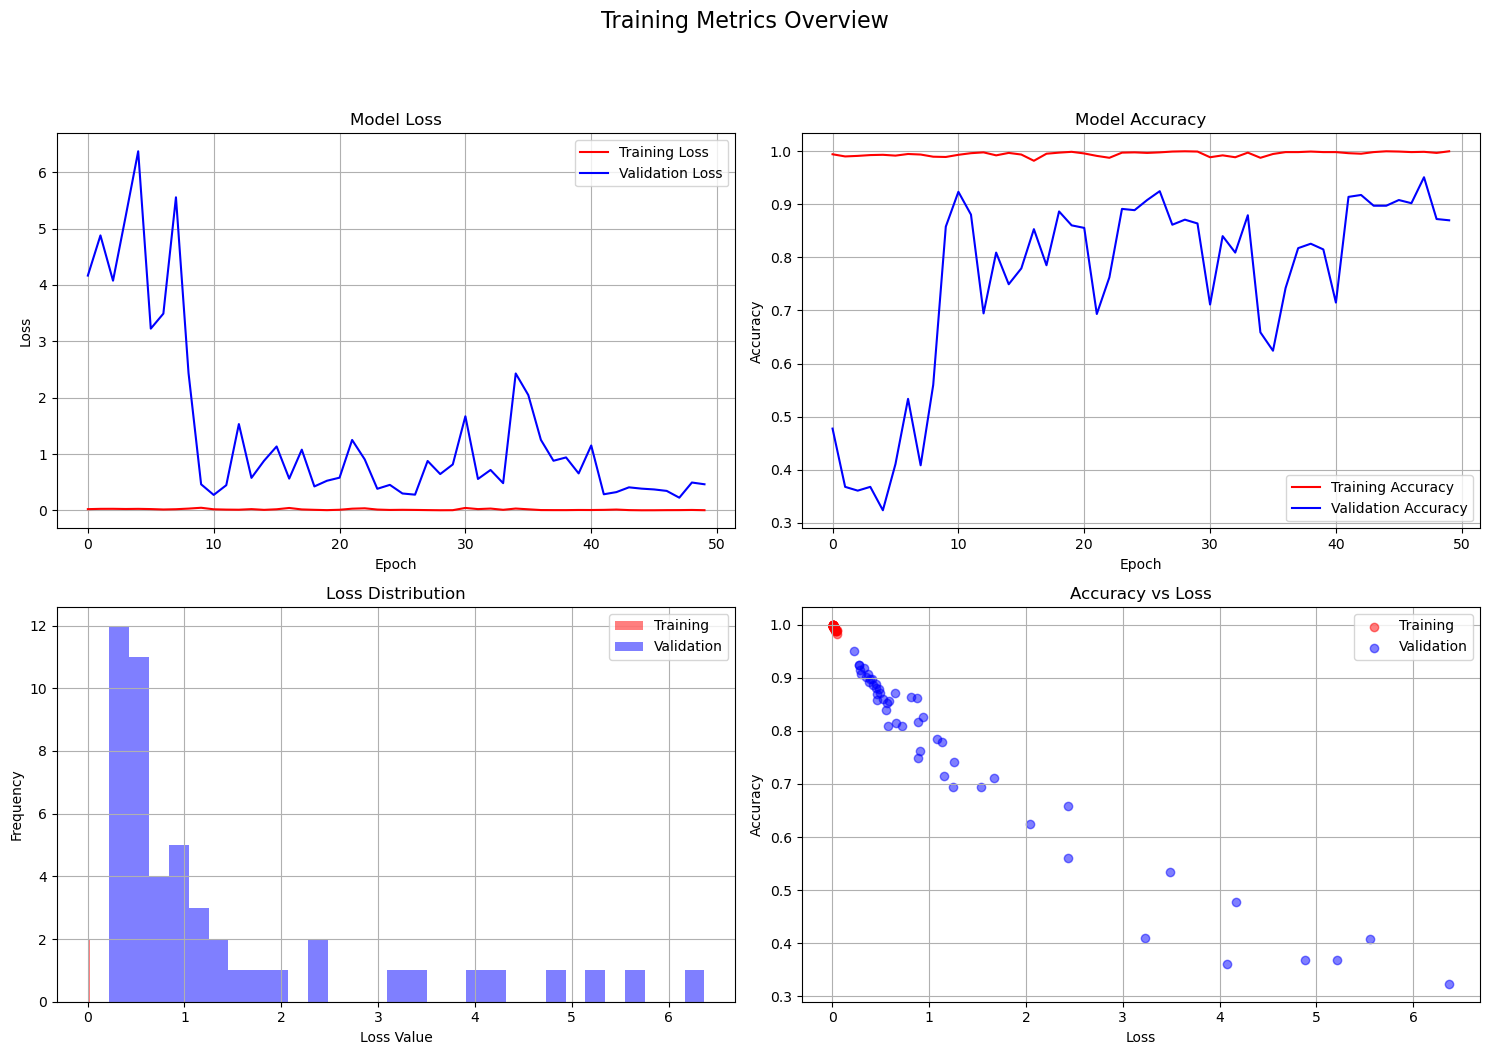


Final Training Metrics:
--------------------------------------------------
Final Training Loss: 0.0037
Final Validation Loss: 0.4636
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8699

Model Improvement:
--------------------------------------------------
Loss Improvement: 0.0187
Accuracy Improvement: 0.0056


In [12]:
enhanced_history = history1

def plot_training_metrics(history_dict):
    """
    Plot comprehensive training metrics including loss, accuracy, and learning rate
    """
    metrics = ['loss', 'accuracy']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training Metrics Overview', fontsize=16, y=1.05)

    # Plot loss
    ax = axes[0, 0]
    ax.plot(history_dict['loss'], label='Training Loss', color='red')
    ax.plot(history_dict['val_loss'], label='Validation Loss', color='blue')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True)

    # Plot accuracy
    ax = axes[0, 1]
    ax.plot(history_dict['accuracy'], label='Training Accuracy', color='red')
    ax.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='blue')
    ax.set_title('Model Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.grid(True)

    # Plot loss distribution
    ax = axes[1, 0]
    ax.hist(history_dict['loss'], bins=30, alpha=0.5, color='red', label='Training')
    ax.hist(history_dict['val_loss'], bins=30, alpha=0.5, color='blue', label='Validation')
    ax.set_title('Loss Distribution')
    ax.set_xlabel('Loss Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True)

    # Plot accuracy vs loss
    ax = axes[1, 1]
    ax.scatter(history_dict['loss'], history_dict['accuracy'],
              c='red', alpha=0.5, label='Training')
    ax.scatter(history_dict['val_loss'], history_dict['val_accuracy'],
              c='blue', alpha=0.5, label='Validation')
    ax.set_title('Accuracy vs Loss')
    ax.set_xlabel('Loss')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print("-" * 50)
    print(f"Final Training Loss: {history_dict['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history_dict['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history_dict['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history_dict['val_accuracy'][-1]:.4f}")

    # Calculate improvement
    print("\nModel Improvement:")
    print("-" * 50)
    print(f"Loss Improvement: {history_dict['loss'][0] - history_dict['loss'][-1]:.4f}")
    print(f"Accuracy Improvement: {history_dict['accuracy'][-1] - history_dict['accuracy'][0]:.4f}")

# Use the function after training
plot_training_metrics(enhanced_history.history)

In [8]:
import pickle

# Define paths for saving
h5_model_path = r"C:\Users\USER\Documents\CNN\base_model_1.h5"
pickle_model_path = r"C:\Users\USER\Documents\CNN\base_model_1.pkl"

# Save as HDF5
model1.save(h5_model_path)
print(f"Model saved as HDF5 to {h5_model_path}")

# Save as Pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model1, f)
print(f"Model saved as Pickle to {pickle_model_path}")

Model saved as HDF5 to C:\Users\USER\Documents\CNN\base_model_1.h5
Model saved as Pickle to C:\Users\USER\Documents\CNN\base_model_1.pkl
